In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

seed = 142856
torch.manual_seed(seed)

In [2]:
col_desc = {
    'AGYSUB': 'Agency',
    'LOC': 'Location',
    'AGELVL': 'Age (bucket)',
    'EDLVL': 'Education level',
    'GSEGRD': 'General schedule & Equivalent grade',
    'LOSLVL': 'Length of service (bucket)',
    'OCC': 'Occupation',
    'PATCO': 'Occupation category',
    'PPGRD': 'Pay Plan & Grade',
    'STEMOCC': 'STEM Occupation',
    'SUPERVIS': 'Supervisory status',
    'TOA': 'Type of appointment',
    'WORKSCH': 'Work schedule',
    'WORKSTAT': 'Work status',
    'LOS': 'Average length of service',
    'SALBUCKET': 'Salary bucket'
}

In [3]:
data_path    = Path('../data/')
model_folder = Path('../models/')
model_path   = model_folder / 'edlvl_clf_salary_bucket.pt'
df           = pd.read_csv(data_path / 'interim' / 'fed_emp.csv')
emb_dim      = 5

In [4]:
# Removing the nan values in columns by either adding a new category
# or dropping the lines
df                                   = df[~df.EDLVL.isnull()]
df.loc[df.GSEGRD.isnull(), 'GSEGRD'] = 0
df.loc[df.OCC.isnull(), 'OCC']       = 0
df                                   = df[~df.SUPERVIS.isnull()]
df                                   = df[~df.TOA.isnull()]
df                                   = df[~df.SALARY.isnull()]
df                                   = df[~df.LOS.isnull()]
# Target generation, we partition the salary values in 10 equally sized
# buckets.
df['SALBUCKET']                      = pd.qcut(df.SALARY, np.arange(0, 1.1, .1))
# df.isnull().sum(axis = 0)

In [5]:
# Dataset truncation to improve overfitting capabilities
df = df.sample(10000, random_state = seed)

In [6]:
df_data    = df.drop(['SALBUCKET', 'SALARY', 'SALLVL'], axis = 1)
df_target  = df['SALBUCKET']

In [7]:
numerical_columns = ['LOS']
df_num            = df_data[numerical_columns]
num_val_mean      = df_num.mean(axis = 0)
num_val_std       = df_num.std(axis = 0)
df_num            = (df_num - num_val_mean) / num_val_std
df_cat            = df_data.drop(numerical_columns, axis = 1) 

In [8]:
columns_encoders = {
    col : {
        val : i 
        for i, val in enumerate(df[col].unique())
    }
    for col in df_cat.columns
}
target_encoder = {
    val : i 
    for i, val in enumerate(sorted(df_target.unique()))
}
column_order = sorted(columns_encoders.keys())

In [9]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].apply(lambda x: columns_encoders[col][x])
df_target = df_target.map(lambda x: target_encoder[x])

In [10]:
class CategoricalEmbeddings(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(CategoricalEmbeddings, self).__init__()
        self.col_order = col_order 
        self.cat_embs  = nn.ModuleDict({
            col: nn.Embedding(len(col_encoders[col]), col_to_emb_dim[col])
            for col in col_order
        })
        
    def forward(self, cat_variables):
        embeddings = [self.cat_embs[col](cat_variables[col]) for col in self.col_order]
        
        return torch.cat(embeddings, dim = 1)

In [11]:
class EdlvlClassifier(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim, class_number, num_var_number, 
                 lin_size = 256, dropout_rate = 0.):
        super(EdlvlClassifier, self).__init__()
        self.cat_emb    = CategoricalEmbeddings(col_order, col_encoders, col_to_emb_dim)
        sum_cat_emb_dim = sum(col_to_emb_dim.values())
        self.linear1    = nn.Linear(sum_cat_emb_dim + num_var_number, lin_size)
        self.linear2    = nn.Linear(lin_size, class_number)
        self.dropout    = nn.Dropout(dropout_rate)
        
    def forward(self, cat_variables, num_variables):
        cat_embeddings = self.cat_emb(cat_variables)
        cat_num_tensor = torch.cat([cat_embeddings, num_variables], dim = 1)
        cat_num_tensor = self.dropout(cat_num_tensor)
        out_linear1    = F.relu(self.dropout(self.linear1(cat_num_tensor)))
        out_linear2    = self.linear2(out_linear1)
        
        return out_linear2

In [12]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : emb_dim
        for col in columns_encoders
    },
    len(target_encoder),
    num_var_number = df_num.shape[1]
)
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(11, 5)
      (AGYSUB): Embedding(351, 5)
      (EDLVL): Embedding(21, 5)
      (GSEGRD): Embedding(16, 5)
      (LOC): Embedding(78, 5)
      (LOSLVL): Embedding(10, 5)
      (OCC): Embedding(459, 5)
      (PATCO): Embedding(7, 5)
      (PPGRD): Embedding(384, 5)
      (STEMOCC): Embedding(86, 5)
      (SUPERVIS): Embedding(6, 5)
      (TOA): Embedding(15, 5)
      (WORKSCH): Embedding(7, 5)
      (WORKSTAT): Embedding(2, 5)
    )
  )
  (linear1): Linear(in_features=71, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.0)
)

In [13]:
dataset = TensorDataset(
    *[
        torch.tensor(df_cat[col].values)
        for col in column_order
    ], # categorical variables in the correct order
    torch.tensor(df_num.values, dtype = torch.float32), # numerical variables
    torch.tensor(df_target.values, dtype = torch.int64) # target variables
)

In [14]:
dataset_size                 = len(dataset)
valid_prop                   = 0.2
valid_size                   = round(valid_prop * dataset_size)
lengths                      = [dataset_size - valid_size, valid_size]
train_dataset, valid_dataset = random_split(dataset, lengths)

In [15]:
train        = True
device       = torch.device('cuda')
model        = model.to(device)
epochs       = 200
batch_size   = 2048
optimizer    = optim.Adam(model.parameters())
criterion    = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [16]:
if train:
    for epoch in range(epochs):
        correct = 0
        total   = 0
        for i, (*cat_var_list, num_var, y) in enumerate(train_loader):
            optimizer.zero_grad()
            cat_var_list   = [t.to(device) for t in cat_var_list]
            num_var        = num_var.to(device)
            y              = y.to(device)
            cat_variables  = dict(zip(column_order, cat_var_list))
            res            = model(cat_variables, num_var)
            loss           = criterion(res, y)
            correct       += (res.argmax(dim = 1) == y).detach().sum().item()
            total         += y.shape[0]
            loss.backward()
            optimizer.step()
#             if i % 50 == 0:
#                 print(f'[{epoch}:{i}] {loss.item()}')
        model.eval()
        valid_correct = 0
        valid_total   = 0
        with torch.no_grad():
            for *cat_var_list, num_var, y in valid_loader:
                cat_var_list   = [t.to(device) for t in cat_var_list]
                num_var        = num_var.to(device)
                y              = y.to(device)
                cat_variables  = dict(zip(column_order, cat_var_list))
                res            = model(cat_variables, num_var)
                valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
                valid_total   += y.shape[0]
        print(f'[{epoch}:{i}] [T] {100. * correct / total:5.2f}%, [V] {100. * valid_correct / valid_total:5.2f}% {loss.item():5.2f}')
        model.train()

    torch.save(model.state_dict(), model_path)

[0:3] [T] 14.78%, [V] 21.10%  2.25
[1:3] [T] 25.52%, [V] 29.55%  2.15
[2:3] [T] 32.94%, [V] 33.50%  2.07
[3:3] [T] 36.35%, [V] 36.80%  1.98
[4:3] [T] 37.81%, [V] 36.65%  1.89
[5:3] [T] 38.50%, [V] 37.85%  1.81
[6:3] [T] 39.71%, [V] 39.95%  1.74
[7:3] [T] 41.17%, [V] 41.45%  1.67
[8:3] [T] 42.58%, [V] 42.30%  1.60
[9:3] [T] 43.54%, [V] 43.70%  1.54
[10:3] [T] 44.34%, [V] 44.30%  1.49
[11:3] [T] 44.85%, [V] 44.45%  1.45
[12:3] [T] 45.58%, [V] 44.85%  1.42
[13:3] [T] 46.49%, [V] 45.65%  1.38
[14:3] [T] 47.51%, [V] 45.40%  1.35
[15:3] [T] 48.12%, [V] 45.95%  1.33
[16:3] [T] 48.77%, [V] 46.40%  1.37
[17:3] [T] 49.35%, [V] 47.30%  1.31
[18:3] [T] 49.83%, [V] 48.20%  1.28
[19:3] [T] 50.52%, [V] 48.15%  1.25
[20:3] [T] 51.15%, [V] 48.10%  1.23
[21:3] [T] 51.74%, [V] 48.95%  1.24
[22:3] [T] 52.06%, [V] 48.55%  1.22
[23:3] [T] 52.71%, [V] 48.70%  1.24
[24:3] [T] 53.04%, [V] 49.15%  1.21
[25:3] [T] 53.48%, [V] 49.40%  1.21
[26:3] [T] 54.31%, [V] 49.00%  1.20
[27:3] [T] 54.59%, [V] 49.60%  1.18
[2

In [17]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : emb_dim
        for col in columns_encoders
    },
    len(target_encoder),
    num_var_number = df_num.shape[1]

).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
valid_correct = 0
valid_total   = 0
with torch.no_grad():
    for *cat_var_list, num_var, y in valid_loader:
        cat_var_list   = [t.to(device) for t in cat_var_list]
        num_var        = num_var.to(device)
        y              = y.to(device)
        cat_variables  = dict(zip(column_order, cat_var_list))
        res            = model(cat_variables, num_var)
        valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
        valid_total   += y.shape[0]
print(valid_correct / valid_total)

0.547


In [18]:
# sample_idx = 20

In [19]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# res            = model(cat_variables, num_var.unsqueeze(0))
# print(res.argmax(dim = 1).item(), y.item())

In [20]:
# def plot(index, res, x_label, correct_index = None):
#     fig, ax = plt.subplots(figsize = (15, 10))
#     bar_width = .70
#     if correct_index is None:
#         ax.bar(index, res, bar_width)
#     else:
#         barlist = ax.bar(index, res, bar_width)
#         barlist[correct_index].set_color('r')
#     ax.set_xticks(index)
#     ax.set_xticklabels(index)
#     ax.set_title(f'Prediction confidence by {x_label} on a specific sample')
#     ax.set_xlabel(x_label)
#     ax.set_ylabel('Confidence')
    
# plot(np.arange(len(res[0])), torch.softmax(res, dim = 1).detach().cpu().numpy()[0], 'pred_class', y.item())

In [21]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# res            = model(cat_variables, num_var.unsqueeze(0))
# print(y.item(), res.argmax(dim = 1).item())
# print(cat_variables)

In [22]:
# *cat_var_list, num_var, y = train_dataset[sample_idx]
# cat_var_list   = [t.to(device) for t in cat_var_list]
# num_var        = num_var.to(device)
# y              = y.to(device)
# cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
# orig_age_lvl   = cat_variables['AGELVL'].item()
# confidences = []
# age_lvls = list(range(12))
# for age_lvl in age_lvls:
#     cat_variables['AGELVL'][0] = age_lvl
#     res = model(cat_variables, num_var.unsqueeze(0))
#     res = torch.softmax(res, dim = 1)
#     confidences.append(res[0, y].item())

# plot(age_lvls, confidences, 'AGELVL', orig_age_lvl)

In [23]:
def plot_both_figures(sample_idx, col, bar_width = 0.7, figsize = (25, 12)):
    *cat_var_list, num_var, y = train_dataset[sample_idx]
    cat_var_list              = [t.to(device) for t in cat_var_list]
    num_var                   = num_var.to(device)
    y                         = y.to(device)
    cat_variables             = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
    pred                      = model(cat_variables, num_var.unsqueeze(0))
    print(f'target: {y.item()}, model pred: {pred.argmax(dim = 1).item()}')
    orig_col_value            = cat_variables[col].item()
    confidences               = []
    col_values                = list(range(len(df[col].unique())))
    print(cat_variables)
    for col_val in col_values:
        cat_variables[col][0] = col_val
        res = model(cat_variables, num_var.unsqueeze(0))
        res = torch.softmax(res, dim = 1)
#        confidences.append(res[0, y].item())
        confidences.append(res.max())
    
    fig, ax = plt.subplots(
        nrows = 1, 
        ncols = 2, 
        figsize = figsize
    )
    class_index = list(range(len(df_target.unique())))
    ax[0].set_xticks(class_index)
    ax[0].set_xticklabels(class_index)
    barlist = ax[0].bar(class_index, torch.softmax(pred, dim = 1).detach().cpu().numpy()[0], bar_width)
    barlist[y.item()].set_color('r')
    ax[0].set_title(f'Model prediction confidence by class')
    ax[0].set_xlabel(col_desc[df_target.name])
    ax[0].set_ylabel('Confidence')
    
    ax[1].set_xticks(col_values)
    ax[1].set_xticklabels(col_values)
    barlist = ax[1].bar(col_values, confidences, bar_width)
    barlist[orig_col_value].set_color('r')
    ax[1].set_title(f'Model prediction confidence while varying a column')
    ax[1].set_xlabel(col_desc[col])
    ax[1].set_ylabel('Confidence')

target: 5, model pred: 5
{'AGELVL': tensor([0], device='cuda:0'), 'AGYSUB': tensor([82], device='cuda:0'), 'EDLVL': tensor([0], device='cuda:0'), 'GSEGRD': tensor([3], device='cuda:0'), 'LOC': tensor([16], device='cuda:0'), 'LOSLVL': tensor([2], device='cuda:0'), 'OCC': tensor([98], device='cuda:0'), 'PATCO': tensor([0], device='cuda:0'), 'PPGRD': tensor([136], device='cuda:0'), 'STEMOCC': tensor([1], device='cuda:0'), 'SUPERVIS': tensor([0], device='cuda:0'), 'TOA': tensor([3], device='cuda:0'), 'WORKSCH': tensor([3], device='cuda:0'), 'WORKSTAT': tensor([1], device='cuda:0')}


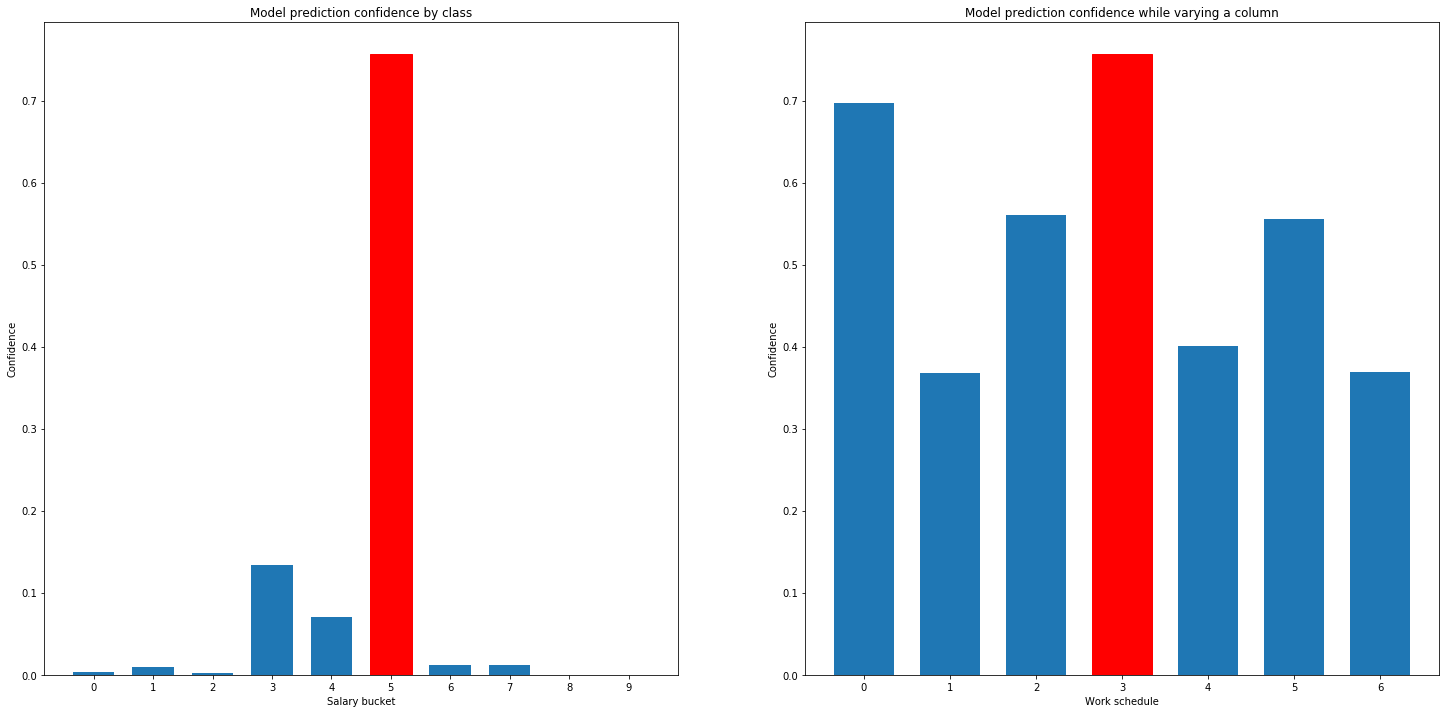

In [56]:
plot_both_figures(73, 'WORKSCH')

In [25]:
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(11, 5)
      (AGYSUB): Embedding(351, 5)
      (EDLVL): Embedding(21, 5)
      (GSEGRD): Embedding(16, 5)
      (LOC): Embedding(78, 5)
      (LOSLVL): Embedding(10, 5)
      (OCC): Embedding(459, 5)
      (PATCO): Embedding(7, 5)
      (PPGRD): Embedding(384, 5)
      (STEMOCC): Embedding(86, 5)
      (SUPERVIS): Embedding(6, 5)
      (TOA): Embedding(15, 5)
      (WORKSCH): Embedding(7, 5)
      (WORKSTAT): Embedding(2, 5)
    )
  )
  (linear1): Linear(in_features=71, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.0)
)